In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import electronbeam
import matplotlib.pyplot as plt
from beam import interactions
from ionization import ionization
from lens import profile
import matplotlib.gridspec as gridspec
import beam.calc.electron as ecalc
import scipy.constants as const
from scipy.interpolate import interp1d
import beam.calc.electron as ecalc
plt.style.use('notes')

path = '/media/robert/Data_Storage/Data/MagnusExpansion/'

In [2]:
# Non-linear focusing with the example ramp from the paper
# Magnus expansion for a single particle in a linear ramp
N = 3500
beta0 = 1
alpha0 = 0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.1
z, dz = np.linspace(0, 100, N, retstep=True)
frac = 1/(1+a*z)**2
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
betam = 1+a*z

In [3]:
# Linear focusing
Np = 1000
electronParams = {
    'name' : 'LinearRamp',
    'path' : path,
    'load' : False,
    'N' : Np,
    'gamma' : gb0,
    'emittance' : 3.0e-6,
    'betax' : beta0,
    'betay' : beta0,
    'alphax' : alpha0,
    'alphay' : alpha0,
    'sigmaz' : 5e-6,
    'dE' : 0.00
}

beam = electronbeam.GaussianElectronBeam(electronParams)
#beam = electronbeam.ElectronBeam(electronParams)
#beam.plot_current_phase()

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        return 0.0
    
plasmaDen = plasmaCls()
dumpPer = 1
interactions.electron_plasma(beam, plasmaDen, z*1e6, dumpPer, 4)
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
m = int(N/dumpPer)
beam_z, dz = np.linspace(0, 100, m, retstep=True)
beam_ne = interp1d(z, ne)(beam_z)
beam_bm = interp1d(z, betam)(beam_z)

In [4]:
# Calculate the first order magnus expansion
Omega11 = lambda s: 0
Omega12 = lambda s: s
Omega21 = lambda s: -s/(1+a*s)
Omega22 = lambda s: 0
theta = lambda s: np.sqrt(Omega11(s)*Omega22(s)-Omega12(s)*Omega21(s))
M11 = lambda s: np.cos(theta(s))
M12 = lambda s: Omega12(s)*np.sin(theta(s))/theta(s)
M21 = lambda s: Omega21(s)*np.sin(theta(s))/theta(s)
M22 = lambda s: np.cos(theta(s))

In [5]:
# Exact solution
c1 = lambda x0, xp0: x0
c2 = lambda x0, xp0: (a*x0/2 - xp0)/np.sqrt(1-a**2/4)
phi = lambda s: -np.sqrt(1-a**2/4)/a*np.log(1+a*s)

/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


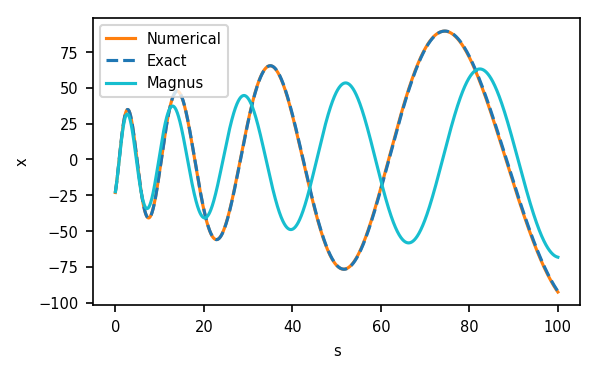

In [28]:
# Load some individual particles
ptcls = np.zeros((m, Np, 6), dtype='double')
for i in range(m):
    ptcls[i, :, :] = beam.load_ptcls(i)[0]

x = lambda s, i: ptcls[0, i, 0]*M11(s) + ptcls[0, i, 1]*M12(s)
xe = lambda s, i: (c1(ptcls[0, i, 0], ptcls[0, i, 1])*np.cos(phi(s))*np.sqrt(1+a*s) +
                   c2(ptcls[0, i, 0], ptcls[0, i, 1])*np.sin(phi(s))*np.sqrt(1+a*s))

ind = 11
plt.figure(figsize=(4, 2.5), dpi=150)
plt.plot(beam_z, ptcls[:, ind, 0]*1e6, 'C1')
plt.plot(beam_z, xe(beam_z, ind)*1e6, 'C0--')
plt.plot(beam_z, x(beam_z, ind)*1e6, 'C9')
plt.xlabel('s')
plt.ylabel('x')
plt.legend(['Numerical', 'Exact', 'Magnus'])
plt.tight_layout()
plt.show()

In [48]:
# Calculate the second order magnus expansion
I = lambda s: s*(2+a*s)/(a+a**2*s)-2*np.log(1+a*s)/a**2
G = lambda s: s/(1+a*s)
Omega11 = lambda s: I(s)/2
Omega12 = lambda s: s
Omega21 = lambda s: -G(s)
Omega22 = lambda s: -I(s)/2
theta = lambda s: np.sqrt(Omega11(s)*Omega22(s)-Omega12(s)*Omega21(s))
M11 = lambda s: np.cos(theta(s)) + Omega11(s)*np.sin(theta(s))/theta(s)
M12 = lambda s: Omega12(s)*np.sin(theta(s))/theta(s)
M21 = lambda s: Omega21(s)*np.sin(theta(s))/theta(s)
M22 = lambda s: np.cos(theta(s)) + Omega22(s)*np.sin(theta(s))/theta(s)
det = lambda s: Omega11(s)*Omega22(s)-Omega12(s)*Omega21(s)
det(12)

-5.5596358421360605

/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt
/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


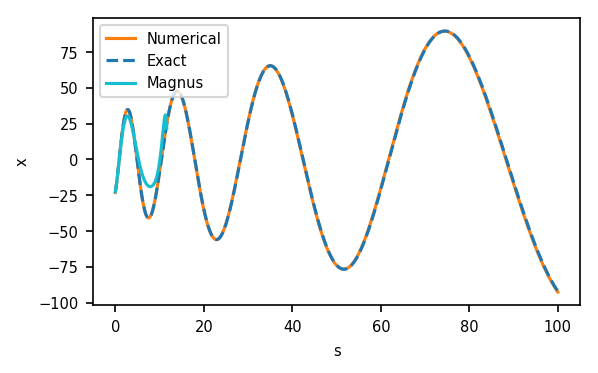

x0: -23.08, x'0: 19.38


In [51]:
# Load some individual particles
ptcls = np.zeros((m, Np, 6), dtype='double')
for i in range(m):
    ptcls[i, :, :] = beam.load_ptcls(i)[0]

x = lambda s, i: ptcls[0, i, 0]*M11(s) + ptcls[0, i, 1]*M12(s)
xe = lambda s, i: (c1(ptcls[0, i, 0], ptcls[0, i, 1])*np.cos(phi(s))*np.sqrt(1+a*s) +
                   c2(ptcls[0, i, 0], ptcls[0, i, 1])*np.sin(phi(s))*np.sqrt(1+a*s))

ind = 11
plt.figure(figsize=(4, 2.5), dpi=150)
plt.plot(beam_z, ptcls[:, ind, 0]*1e6, 'C1')
plt.plot(beam_z, xe(beam_z, ind)*1e6, 'C0--')
plt.plot(beam_z, x(beam_z, ind)*1e6, 'C9')
plt.xlabel('s')
plt.ylabel('x')
plt.legend(['Numerical', 'Exact', 'Magnus'])
plt.tight_layout()
plt.show()
print("x0: %0.2f, x'0: %0.2f" % (ptcls[0, ind, 0]*1e6, ptcls[0, ind, 1]*1e6))